In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the pbmc3k dataset
adata = sc.datasets.pbmc3k()

print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata)


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'


In [4]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Store the raw data
adata.raw = adata



In [5]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


1872


In [6]:
adata

View of AnnData object with n_obs × n_vars = 2700 × 1872
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### Zifa

ZIFA has an n_componet like as K , I still did that since I didn't know when i started
I have tried n_genes 30, 100 & 500

In [7]:
# Import Libraries
from ZIFA import ZIFA
from ZIFA import block_ZIFA
import numpy as np



In [8]:
# ZIFA is designed to work with count data, so we need to make sure we're using the raw counts before normalization and log-transformation.
# If you have stored the raw data in adata.raw, you can use that; otherwise, make sure to use the original count data.
X_counts = adata.raw.X.toarray() if adata.raw is not None else adata.X.toarray()
X_counts.shape

(2700, 13714)

In [14]:
# Set the threshold for zero inflation
p0_thresh = 0.9  # This will filter out genes that are zero in more than 80% of cells

# Set the number of dimensions and blocks
n_components = 4 # ZIFA often works better with fewer components

# Set the number of genes per block to speed up the computation
n_genes_per_block = 100  # Adjust this number based on your dataset

# Calculate the number of blocks based on the new genes per block
n_blocks = max(int(X_counts.shape[1] / n_genes_per_block), 1)  # Ensure at least one block

# Fit the block ZIFA model
Z, model_params = block_ZIFA.fitModel(X_counts, n_components, n_blocks=n_blocks, p0_thresh=p0_thresh)

# The result is in Z, which we can add back to the AnnData object
adata.obsm['X_block_zifa'] = Z



Filtering out all genes which are zero in more than 90.0% of samples. To change this, change p0_thresh.
Running block zero-inflated factor analysis with N = 2700, D = 2112, K = 4, n_blocks = 137
Block sizes [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 72]


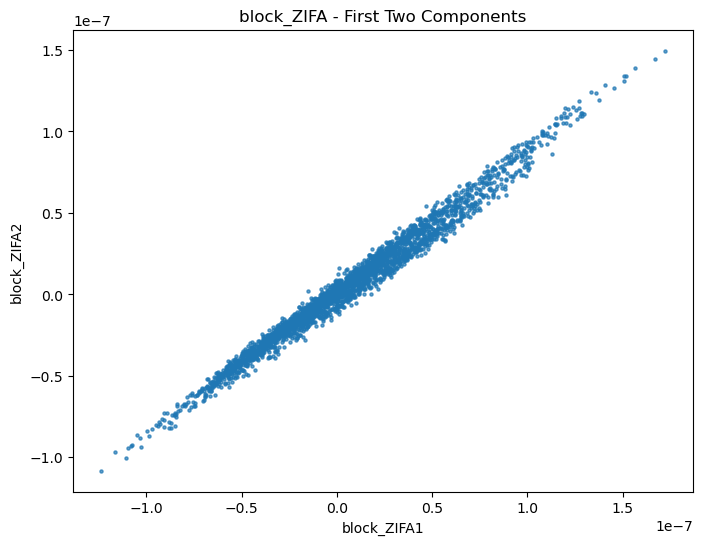

In [13]:
# Visualize the results
# Extract the first two block_ZIFA components
block_zifa_comp1 = adata.obsm['X_block_zifa'][:, 0]
block_zifa_comp2 = adata.obsm['X_block_zifa'][:, 1]

# Create a scatter plot of the first two block_ZIFA components
plt.figure(figsize=(8, 6))
plt.scatter(block_zifa_comp1, block_zifa_comp2, s=5, alpha=0.7)
plt.title('block_ZIFA - First Two Components')
plt.xlabel('block_ZIFA1')
plt.ylabel('block_ZIFA2')
plt.show()
